In [53]:
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer,AdagradOptimizer
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
from autoencoder import Autoencoder
from autoencoder2 import Autoencoder_c11
import warnings
warnings.filterwarnings("ignore")
import os 
from autoencoder3 import Autoencoder_composite
from autoencoder4 import Autoencoder_iterative
import time


In [54]:
custom_palette =[
    # '#C24AA2','#D6518F',
    '#EC5A77','#F57C73','#F69C6D','#F6BC66']

In [55]:
range_qubit_autoencoder=list(range(2,7))
range_batches = [10,20,50,100]
seed=42
epochs=150
n=150
stepsize=.25
opt=AdamOptimizer(stepsize=stepsize)
X=np.random.rand(n)*np.pi*2


Running AE with 2 input qubit and 1 trash qubit in batches of 10
Stage: 0, 	Epoch 9, 	Batch:9, 	Train Loss = 0.000419, 	Val Loss = 0.000433
Early stop

--------------------------------------------------
Running AE with 2 input qubit and 1 trash qubit in batches of 20
Stage: 0, 	Epoch 12, 	Batch:4, 	Train Loss = 0.001216, 	Val Loss = 0.001139
Early stop

--------------------------------------------------
Running AE with 2 input qubit and 1 trash qubit in batches of 50
Stage: 0, 	Epoch 23, 	Batch:1, 	Train Loss = 0.000408, 	Val Loss = 0.000436
Early stop

--------------------------------------------------
Running AE with 2 input qubit and 1 trash qubit in batches of 100
Stage: 0, 	Epoch 49, 	Batch:0, 	Train Loss = 0.000445, 	Val Loss = 0.000419
Early stop

--------------------------------------------------
Running AE with 3 input qubit and 2 trash qubit in batches of 10
Stage: 1, 	Epoch 150, 	Batch:9, 	Train Loss = 0.112136, 	Val Loss = 0.119535
------------------------------------------

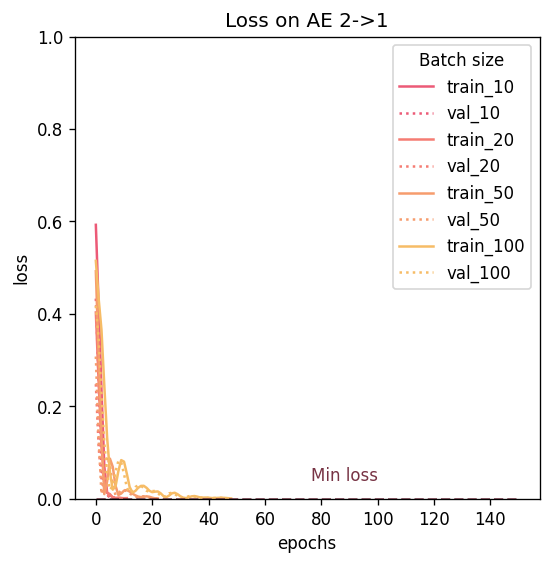

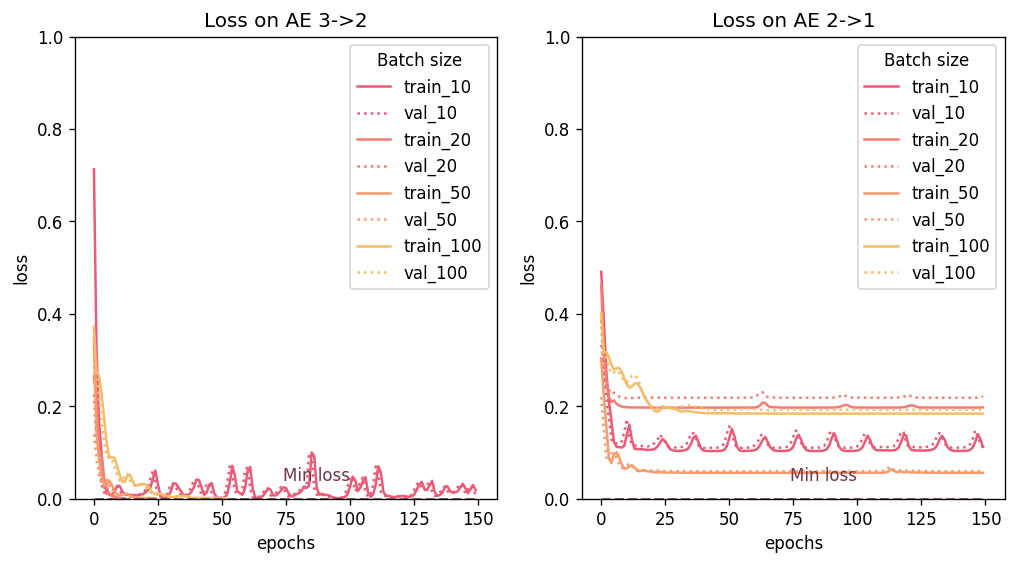

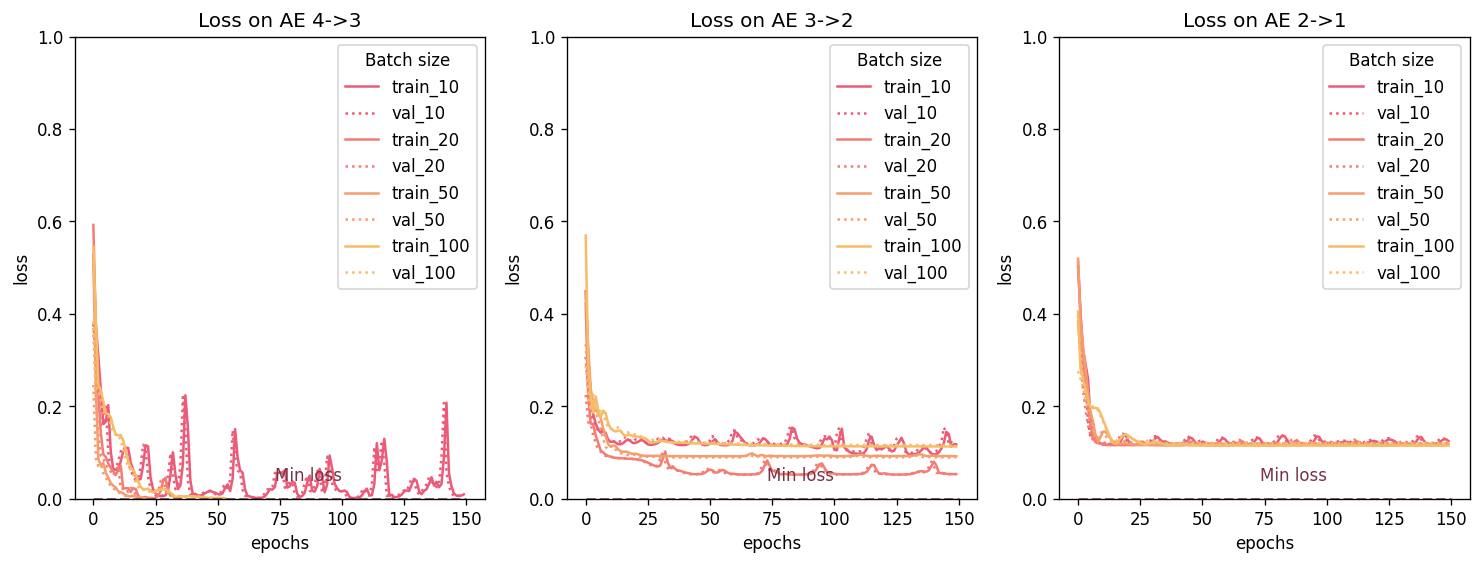

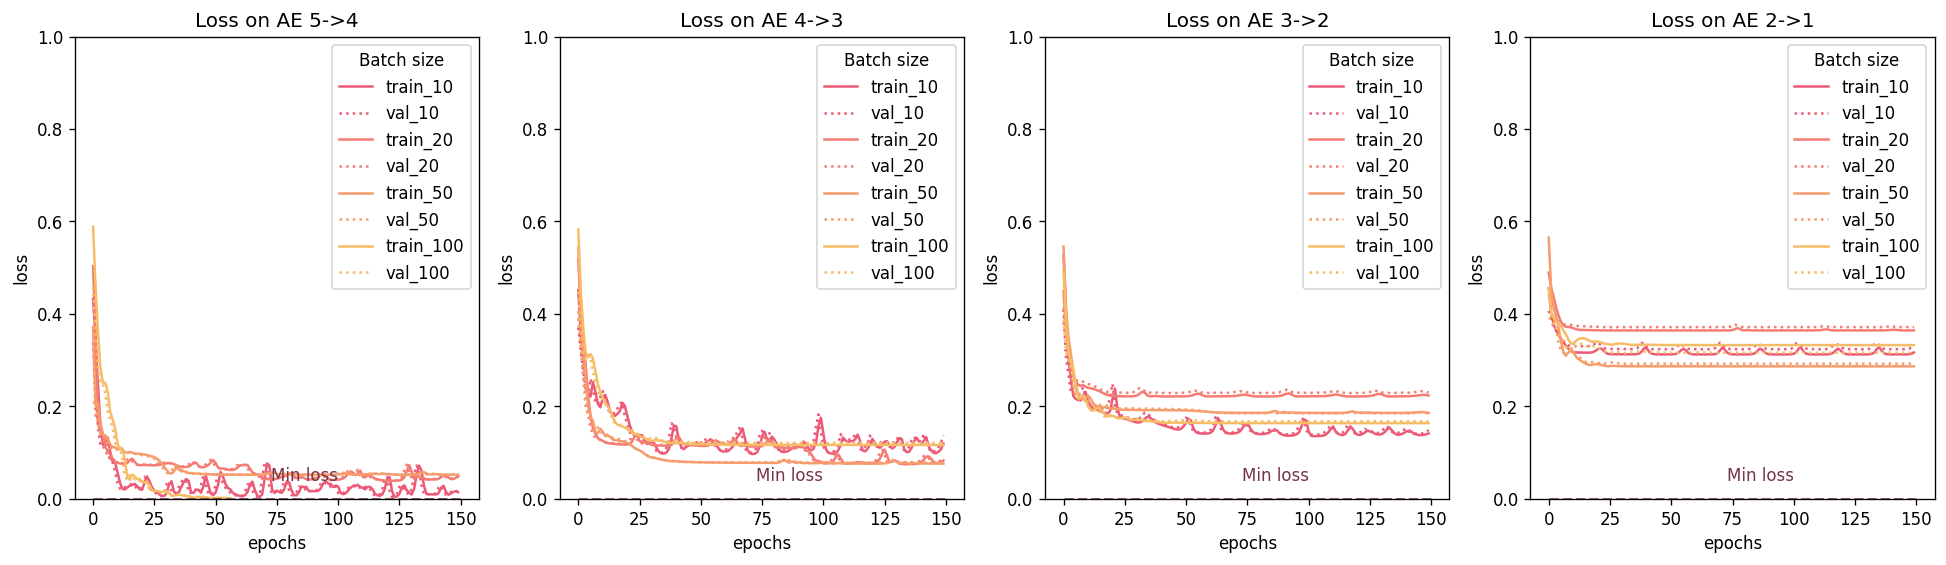

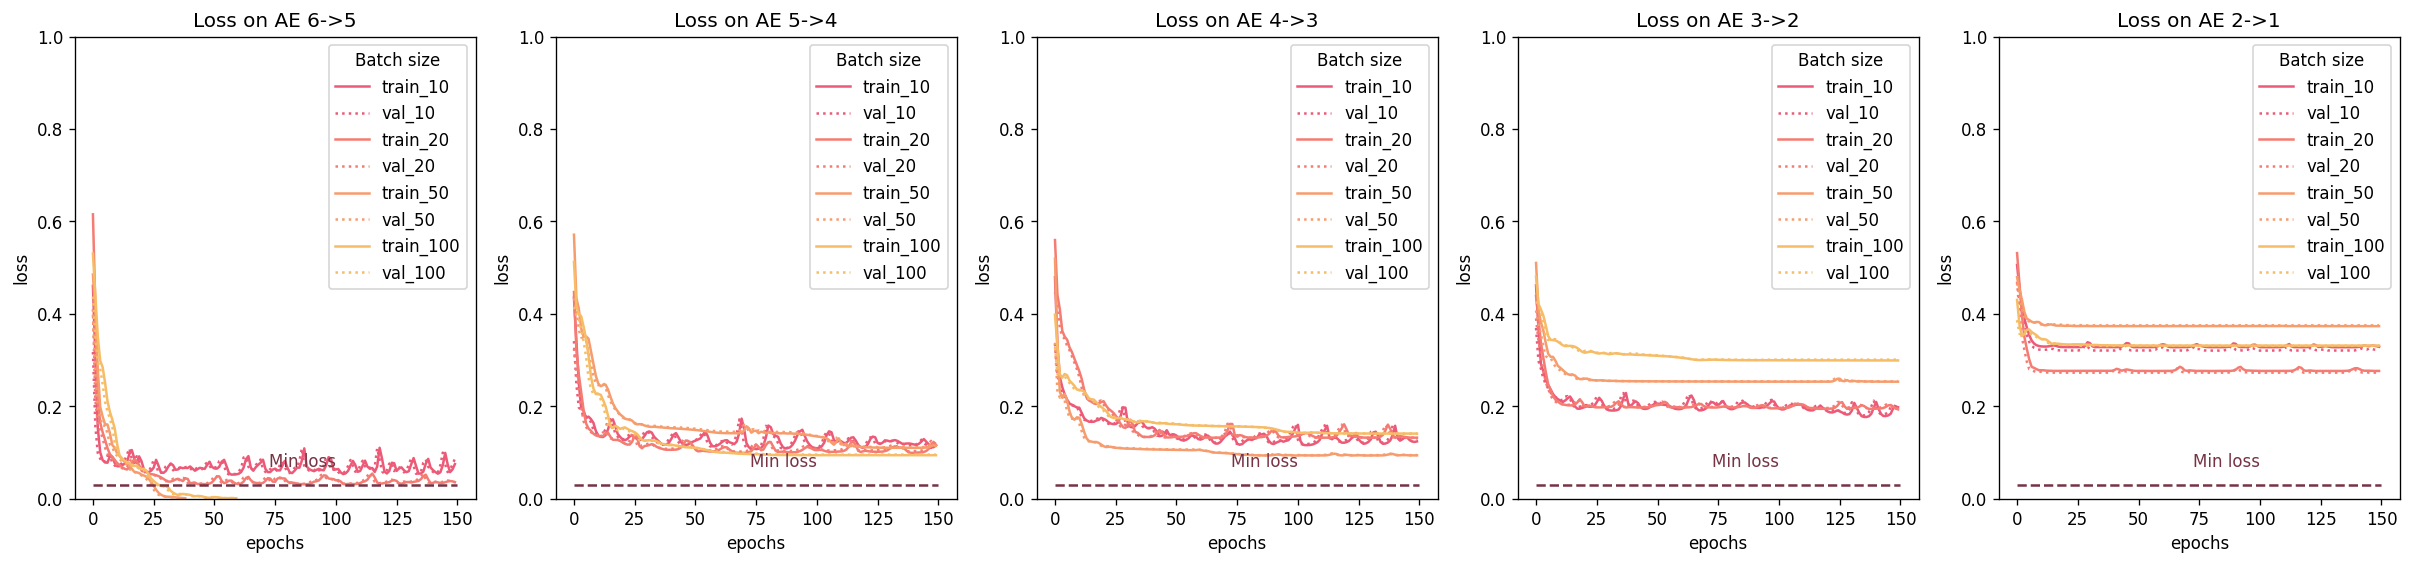

In [56]:
for n_qubit_autoencoder in range_qubit_autoencoder:
    for n_trash_qubit in [n_qubit_autoencoder-1]:
        train_batch_losses={}
        val_batch_losses={}
        batch_times={}
        img_folder=f'runs/run_{n_qubit_autoencoder}to{n_qubit_autoencoder-n_trash_qubit}'
        os.makedirs(img_folder,exist_ok=True)
        for batch_size in range_batches:
            folder=img_folder+f'/{batch_size}'
            print(f"Running AE with {n_qubit_autoencoder} input qubit and {n_trash_qubit} trash qubit in batches of {batch_size}")
            n_qubit=n_qubit_autoencoder
            dvc = qml.device('default.qubit', wires=n_qubit, shots=None)
            ae = Autoencoder_iterative(n_qubit_autoencoder,n_trash_qubit,dvc,arch='c11')
            start_time = time.time()
            ae.train(X,opt,epochs,batch_size,val_split=.33)
            end_time = time.time()

            os.makedirs(folder)
            train_loss,val_loss=ae.get_loss()
            train_batch_losses[batch_size]=train_loss
            val_batch_losses[batch_size]=val_loss
            batch_times[batch_size]=end_time-start_time
            weights=ae.best_params()
            for k,v in train_loss.items():
                np.save(folder+f'/loss_train_{n_qubit_autoencoder-k}_{n_qubit_autoencoder-k-1}',np.array(v))            
                np.save(folder+f'/loss_val_{n_qubit_autoencoder-k}_{n_qubit_autoencoder-k-1}',np.array(v))            
            np.save(folder+'/weights',np.array(weights))

        # Min loss
        min_val_found= [(k, f, min(c)) for k, a_dict in val_batch_losses.items() for f, c in a_dict.items()]
        min_train_found= [(k, f, min(c)) for k, a_dict in train_batch_losses.items() for f, c in a_dict.items()]
        min_loss,rank =get_min_loss_fid(X,n_qubit_autoencoder,n_trash_qubit)
        # Figure
        plt.figure(figsize=(5*n_trash_qubit,5),dpi=120)
        for k in range(n_trash_qubit):
            axs=plt.subplot(1,n_trash_qubit,k+1)

            sns.set_palette(custom_palette)  
            
            for a,b,c,d in zip(list(train_batch_losses.values()),list(val_batch_losses.values()),range_batches,custom_palette):
                sns.lineplot(x=range(len(a[k])),y=a[k], ax=axs,label=f'train_{c}',color=d)
                sns.lineplot(x=range(len(b[k])),y=b[k], ax=axs,label=f'val_{c}', color=d,linestyle=':')
            axs.legend(title='Batch size')

            axs.hlines(min_loss,0,epochs,color='#773344',linestyle='--')
            axs.text(x=epochs//3*2, y=min_loss+0.05, fontsize='medium', s=f'Min loss', color='#773344', ha='right', va='center')
            plt.ylim((0,1))

            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title(f'Loss on AE {n_qubit_autoencoder-k}->{n_qubit_autoencoder-k-1}')
        plt.savefig(img_folder+f'/{n_qubit_autoencoder}_{n_qubit_autoencoder-n_trash_qubit}')
        # Info file 
        with open(img_folder+f'/info.txt','a') as file:
            file.write(f'RUN INFORMATION\nInput qubits={n_qubit_autoencoder}\nTrash qubit={n_trash_qubit}\nSeed={seed}\nOptimizer=AdamOptimizer(stepsize={opt.stepsize})\nEpochs={epochs}\nBatch sizes={range_batches}\nMin fidelity loss={min_loss}\nDensity matrix rank={rank}\nMin val loss found =\n{''.join([f'\t\t\t{n_qubit_autoencoder-a[1]}->{n_qubit_autoencoder-a[1]-1}\t{a[0]}\t:\t{a[2]}\n'  for a in min_val_found])}\nExec (training) time=\n{''.join([f'\t\t\t\t{a}\t:\t{b}\n' for a, b in batch_times.items()])}')